In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

simplefilter(action='ignore', category=FutureWarning)

In [2]:
def cal_5year_moving_avg(time_series):
    time_series = time_series.rolling(5,center=True,min_periods=1,axis=0).mean()
    return time_series

def Regridder(data):
    data = data.interp(lat=target_griddes['lat'],lon=target_griddes['lon'], method="nearest")
    return data

def regrid(data,mask='Global'):
    
    data_regridded = Regridder(data)
    if mask == 'Global':
        data_regridded = data_regridded * mask_global
    elif mask != 'Global':
        data_regridded = sel_lonlat_range(
            mask_global,lon_min=domain_lonlat[mask]['lon_min'],
            lon_max=domain_lonlat[mask]['lon_max'],
            lat_min=domain_lonlat[mask]['lat_min'],
            lat_max=domain_lonlat[mask]['lat_max'])
    else:
        pass
    return data_regridded

def get_mme_series(name,forcing):
    forcing_shortname = {'historical':'hist','hist-GHG':'GHG','hist-aer':'aer','hist-nat':'nat'}
    path = forcing_dir[forcing] + name + '_' + forcing_shortname[forcing] + '_mme_Rx5day.nc'
    mme  = xr.open_dataset(path)
    mme_mask = regrid(data=mme, mask = 'Global')
    area_weights = np.cos(np.deg2rad((mme_mask.lat)))
    area_weights.name = 'weights'
    mme_regrid_weighted = mme_mask.weighted(area_weights)
    mme_weighted_mean = mme_regrid_weighted.mean(("lon", "lat"))
    mme_weighted_mean = mme_weighted_mean[var_name[name]]
    ens_weighted_mean = pd.DataFrame(mme_weighted_mean,index=mme_weighted_mean.time,columns=[name+'_'+forcing])
    ens_weighted_mean = ens_weighted_mean.loc[1960:2014]
    ens_weighted_mean = ens_weighted_mean - ens_weighted_mean.mean()
    return ens_weighted_mean

def get_multi_model_series(name,forcing):
    ensemble = ensembles[forcing]
    ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + name + '_day_' + i + '*.nc')]
    series = pd.DataFrame()
    
    for i in ensemble:
        # print(i)
        src_id = i.split('_')[0]
        run    = i.split('_')[2]
        pi_time = i.split('_')[3]
        ens_i  = Rx5dayCond(name,forcing,src_id,run,mask='Global',pi_time=pi_time)
        ens_i  = ens_i.regrid()
        area_weights = np.cos(np.deg2rad((ens_i.lat)))
        area_weights.name = 'weights'
        ens_i_weighted = ens_i.weighted(area_weights)
        ens_i_weighted_series = ens_i_weighted.mean(("lon", "lat"))
        series[src_id + '_' + run + '_' + pi_time] = ens_i_weighted_series[var_name[name]]

    series = cal_5year_moving_avg(series)
    series = series - series.mean(axis=0)
    var_095 = series.apply(lambda x: x.quantile(0.95),axis=1)
    var_005 = series.apply(lambda x: x.quantile(0.05),axis=1)
    series['var_095'] = var_095
    series['var_005'] = var_005
    series = series.set_axis(range(1960,2015))
    return series

def cal_slope(time_series):
    ts_slope = linregress(range(len(time_series)),time_series).slope
    return ts_slope

from sklearn.utils import resample
def bs_sample(a,iter_nums=1000):
    data = []
    for i in range(iter_nums):
        data.append(resample(a,n_samples=len(a),replace=True))
    return data

def bootstrap_sample(data, n_samples=1000):
    samples = []
    nr = len(data)
    for i in range(n_samples):
        sample = data.iloc[np.random.choice(range(nr), size=nr, replace=True),:]
        samples.append(sample)
    return samples

def bs_sample_std(a,iter_nums=1000):
    data_stds = []
    for i in range(iter_nums):
        data_stds.append(resample(a,n_samples=len(a),replace=True).std())
    data_mean_std = np.mean(data_stds)
    return data_mean_std

def bs_trend_sig(a, iter_num = 1000):
    samples = []
    nr = len(a)
    a = pd.DataFrame({'var':a})
    for i in range(iter_num):
        sample = a.iloc[np.random.choice(range(nr), size=nr, replace=True),:]
        samples.append(sample)

    trend_a = np.polyfit(a.index, a['var'], 1)[0]
    trends = [np.polyfit(s.index, s['var'], 1)[0] for s in samples] 
    trend_025 = np.percentile(trends, q=2.5)
    trend_975 = np.percentile(trends, q=97.5)
    if trend_a > 0:
        if trend_025 > 0:
            sig = 1
        else:
            sig = 0
    else:
        if trend_975 < 0:
            sig = 1
        else:
            sig = 0
    return sig

def get_reanalysis_weighted_for_mask(name,reanalysis):
    prec_reanalysis = Rx5dayCond(name=name,forcing=reanalysis,src_id=reanalysis,run='reanalysis')

    reanalysis_regridded = prec_reanalysis.regrid()
    area_weights = np.cos(np.deg2rad((reanalysis_regridded.lat)))
    area_weights.name = 'weights'
    reanalysis_regridded = reanalysis_regridded.weighted(area_weights)
    reanalysis_regridded = reanalysis_regridded.mean(("lon", "lat"))
    reanalysis_regridded = reanalysis_regridded[var_name[name]]

    reanalysis_trend = cal_slope(reanalysis_regridded)
    reanalysis_trend_sig = bs_trend_sig(reanalysis_regridded)
    reanalysis_regridded = cal_5year_moving_avg(reanalysis_regridded.to_dataframe())
    reanalysis_regridded_ano = reanalysis_regridded - reanalysis_regridded.mean()
    reanalysis_regridded_ano = reanalysis_regridded_ano.values

    return reanalysis_regridded, reanalysis_trend, reanalysis_trend_sig,reanalysis_regridded_ano

In [3]:
forcing_list = ['era5','historical','hist-GHG','hist-aer','hist-nat']
name_list    = ['prec','scaling_thermo','scaling_dynamic']

model_path   = {'historical':'historical','hist-aer':'aer','hist-GHG':'GHG','hist-nat':'nat'}

## prec era5
prec_era5 = Rx5dayCond(name='prec',forcing='era5',src_id='era5',run='reanalysis',mask='Global')
prec_era5 = prec_era5.regrid()
prec_era5 = prec_era5.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((prec_era5.lat)))
area_weights.name = 'weights'
prec_weighted = prec_era5.weighted(area_weights)
prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)
prec_weighted_mean_era5 = prec_weighted_mean['prec_cond'].to_dataframe()
prec_weighted_mean_era5 = cal_5year_moving_avg(prec_weighted_mean_era5)
prec_weighted_mean_era5 = prec_weighted_mean_era5 - prec_weighted_mean_era5.mean()
## scaling_thermo era5
scaling_thermo_era5 = Rx5dayCond(name='scaling_thermo',forcing='era5',src_id='era5',run='reanalysis',mask='Global')
scaling_thermo_era5 = scaling_thermo_era5.regrid()
scaling_thermo_era5 = scaling_thermo_era5.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((scaling_thermo_era5.lat)))
area_weights.name = 'weights'
scaling_thermo_weighted = scaling_thermo_era5.weighted(area_weights)
scaling_thermo_weighted_mean = scaling_thermo_weighted.mean(("lon", "lat"),skipna=True)
scaling_thermo_weighted_mean_era5 = scaling_thermo_weighted_mean['scaling_thermo'].to_dataframe()
scaling_thermo_weighted_mean_era5 = cal_5year_moving_avg(scaling_thermo_weighted_mean_era5)
scaling_thermo_weighted_mean_era5 = scaling_thermo_weighted_mean_era5 - scaling_thermo_weighted_mean_era5.mean()
## scaling_dynamic era5
scaling_dynamic_era5 = Rx5dayCond(name='scaling_dynamic',forcing='era5',src_id='era5',run='reanalysis',mask='Global')
scaling_dynamic_era5 = scaling_dynamic_era5.regrid()
scaling_dynamic_era5 = scaling_dynamic_era5.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((scaling_dynamic_era5.lat)))
area_weights.name = 'weights'
scaling_dynamic_weighted = scaling_dynamic_era5.weighted(area_weights)
scaling_dynamic_weighted_mean = scaling_dynamic_weighted.mean(("lon", "lat"),skipna=True)
scaling_dynamic_weighted_mean_era5 = scaling_dynamic_weighted_mean['scaling_dynamic'].to_dataframe()
scaling_dynamic_weighted_mean_era5 = cal_5year_moving_avg(scaling_dynamic_weighted_mean_era5)
scaling_dynamic_weighted_mean_era5 = scaling_dynamic_weighted_mean_era5 - scaling_dynamic_weighted_mean_era5.mean()

## calculate trends standard error
bar_data_error = pd.DataFrame()
for i in range(3):
    name = name_list[i]
    for f in ['historical','hist-GHG','hist-aer','hist-nat']:
        multi_model_series = get_multi_model_series(name,f)
        multi_model_series_copy = multi_model_series.copy().drop(['var_095','var_005'],axis=1)
        if i == 0:
            multi_model_series_trend = multi_model_series_copy.apply(cal_slope,axis=0) * 10
        else:
            multi_model_series_trend = multi_model_series_copy.apply(cal_slope,axis=0) * 10 * 5 #
        multi_model_series_trend = pd.DataFrame(multi_model_series_trend) #
        multi_model_series_trend['model'] = [i.split('_')[0] for i in ensembles[f]] #
        multi_model_series_trend = multi_model_series_trend.groupby('model').mean() #
        bar_data_error[name + '_' + f] = [bs_sample_std(multi_model_series_trend.values)]

## calculate trends and significance
bar_data = pd.DataFrame()
bar_data_sig = pd.DataFrame()
for i in range(3):
    name = name_list[i]
    for f in ['historical','hist-GHG','hist-aer','hist-nat']:
        multi_model_series = get_multi_model_series(name,f)
        multi_model_series_copy = multi_model_series.copy().drop(['var_095','var_005'],axis=1)
        multi_model_series_copy.columns = [i.split('_')[0] for i in ensembles[f]]
        multi_model_mean_series = multi_model_series_copy.mean(axis=1).to_frame()
        if i == 0:
            multi_model_series_trend = multi_model_mean_series.apply(cal_slope) * 10
        else:
            multi_model_series_trend = multi_model_mean_series.apply(cal_slope) * 10 * 5
        multi_model_series_sig = multi_model_mean_series.apply(bs_trend_sig)
        bar_data[name + '_' + f] = multi_model_series_trend.values
        if multi_model_series_trend.values > 0 :
            multi_model_series_sig = multi_model_series_sig.values & ((multi_model_series_trend - bar_data_error[name + '_' + f][0]) > 0)
        else:
            multi_model_series_sig = multi_model_series_sig.values & ((multi_model_series_trend + bar_data_error[name + '_' + f][0]) < 0)
        bar_data_sig[name + '_' + f] = multi_model_series_sig.values
        

In [4]:
## prec jra55
prec_jra55 = Rx5dayCond(name='prec',forcing='jra55',src_id='jra55',run='reanalysis',mask='Global')
prec_jra55 = prec_jra55.regrid()
prec_jra55 = prec_jra55.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((prec_jra55.lat)))
area_weights.name = 'weights'
prec_weighted = prec_jra55.weighted(area_weights)
prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)
prec_weighted_mean_jra55 = prec_weighted_mean['prec_cond'].to_dataframe()
prec_weighted_mean_jra55 = cal_5year_moving_avg(prec_weighted_mean_jra55)
prec_weighted_mean_jra55 = prec_weighted_mean_jra55 - prec_weighted_mean_jra55.mean()
## scaling_thermo jra55
scaling_thermo_jra55 = Rx5dayCond(name='scaling_thermo',forcing='jra55',src_id='jra55',run='reanalysis',mask='Global')
scaling_thermo_jra55 = scaling_thermo_jra55.regrid()
scaling_thermo_jra55 = scaling_thermo_jra55.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((scaling_thermo_jra55.lat)))
area_weights.name = 'weights'
scaling_thermo_weighted = scaling_thermo_jra55.weighted(area_weights)
scaling_thermo_weighted_mean = scaling_thermo_weighted.mean(("lon", "lat"),skipna=True)
scaling_thermo_weighted_mean_jra55 = scaling_thermo_weighted_mean['scaling_thermo'].to_dataframe()
scaling_thermo_weighted_mean_jra55 = cal_5year_moving_avg(scaling_thermo_weighted_mean_jra55)
scaling_thermo_weighted_mean_jra55 = scaling_thermo_weighted_mean_jra55 - scaling_thermo_weighted_mean_jra55.mean()
## scaling_dynamic jra55
scaling_dynamic_jra55 = Rx5dayCond(name='scaling_dynamic',forcing='jra55',src_id='jra55',run='reanalysis',mask='Global')
scaling_dynamic_jra55 = scaling_dynamic_jra55.regrid()
scaling_dynamic_jra55 = scaling_dynamic_jra55.sel(time=slice('1960','2014'))
area_weights = np.cos(np.deg2rad((scaling_dynamic_jra55.lat)))
area_weights.name = 'weights'
scaling_dynamic_weighted = scaling_dynamic_jra55.weighted(area_weights)
scaling_dynamic_weighted_mean = scaling_dynamic_weighted.mean(("lon", "lat"),skipna=True)
scaling_dynamic_weighted_mean_jra55 = scaling_dynamic_weighted_mean['scaling_dynamic'].to_dataframe()
scaling_dynamic_weighted_mean_jra55 = cal_5year_moving_avg(scaling_dynamic_weighted_mean_jra55)
scaling_dynamic_weighted_mean_jra55 = scaling_dynamic_weighted_mean_jra55 - scaling_dynamic_weighted_mean_jra55.mean()

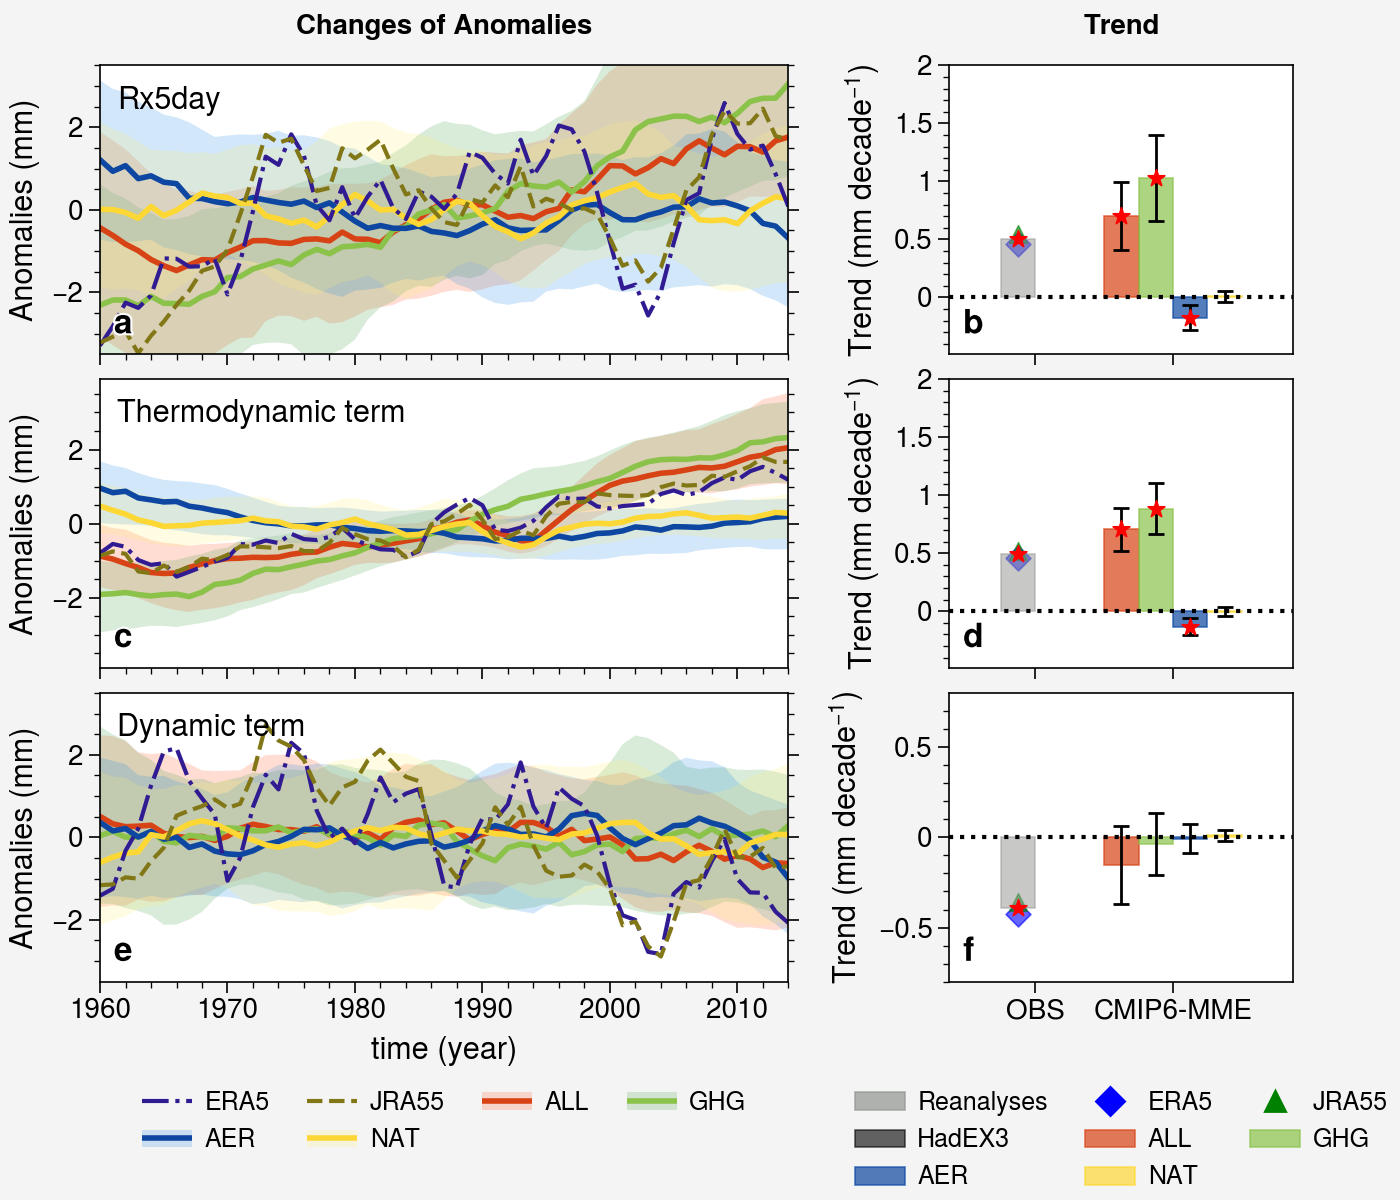

In [5]:
fig, ax = pplot.subplots(ncols=2,nrows=3,wratios=(4,2),wspace=(None),hspace=(1,1),share=False,figsize=(7, 6))
ax.format(grid=False)
ax.format(abc=True,abcsize=12,abcloc='ll')

# row1 for prec
name = 'prec'
index = range(1960,2015)
fb_color = {'historical':'#FF5722','hist-GHG':'#43A047','hist-aer':'#1E88E5','hist-nat':'#FFF176'}
mme_color = {'historical':'#D84315','hist-GHG':'#8BC34A','hist-aer':'#0D47A1','hist-nat':'#FDD835'}
abc_label = ['Rx5day','Thermodynamic term','Dynamic term']
era5_list = ['prec_cond','scaling_thermo','scaling_dynamic']

for i in range(3):
    ax_i = ax[i,0]
    name = name_list[i]
    for f in ['historical','hist-GHG','hist-aer','hist-nat']:
        multi_model_series = get_multi_model_series(name,f)
        if i == 0:
            multi_model_series = cal_5year_moving_avg(multi_model_series)
        else:
            multi_model_series = cal_5year_moving_avg(multi_model_series) * 5
        
        var005 = multi_model_series['var_005']
        var095 = multi_model_series['var_095']
        if f == 'historical':
            a1 = ax_i.fill_between(index,var005,var095,facecolor=fb_color[f],alpha=0.2)
        elif f == 'hist-GHG':
            b1 = ax_i.fill_between(index,var005,var095,facecolor=fb_color[f],alpha=0.2)
        elif f == 'hist-aer':
            c1 = ax_i.fill_between(index,var005,var095,facecolor=fb_color[f],alpha=0.2)
        elif f == 'hist-nat':
            d1 = ax_i.fill_between(index,var005,var095,facecolor=fb_color[f],alpha=0.2)
        else:
            pass

        mme_series = get_mme_series(name,f)
        if i == 0:
            mme_series = cal_5year_moving_avg(mme_series)
        else:
            mme_series = cal_5year_moving_avg(mme_series) * 5
        if f == 'historical':
            a2 = ax_i.plot(index, mme_series, color=mme_color[f],linewidth=2)
        elif f == 'hist-GHG':
            b2 = ax_i.plot(index, mme_series, color=mme_color[f],linewidth=2)
        elif f == 'hist-aer':
            c2 = ax_i.plot(index, mme_series, color=mme_color[f],linewidth=2)
        elif f == 'hist-nat':
            d2 = ax_i.plot(index, mme_series, color=mme_color[f],linewidth=2)
        else:
            pass

    ax_i.set(ylabel='Anomalies (mm)',xlim=[1960,2014])
    ax_i.yaxis.set_ticks_position('both')
    ax_i.tick_params(axis='both', which='major', labelsize=10)
    if i!=2:
        ax_i.xaxis.set_ticklabels([])
    ax_i.text(0.025,0.85,abc_label[i],transform = ax_i.transAxes,size=11)
    ax_i.yaxis.label.set_size(11)

e  = ax[0].plot(index, prec_weighted_mean_era5, color='#311B92',linewidth=1.5,linestyle='-.')
ax[2].plot(index, scaling_thermo_weighted_mean_era5 * 5, color='#311B92',linewidth=1.5,linestyle='-.')
ax[4].plot(index, scaling_dynamic_weighted_mean_era5 * 5, color='#311B92',linewidth=1.5,linestyle='-.')

g  = ax[0].plot(index, prec_weighted_mean_jra55, color='#827717',linewidth=1.5,linestyle='--')
ax[2].plot(index, scaling_thermo_weighted_mean_jra55 * 5, color='#827717',linewidth=1.5,linestyle='--')
ax[4].plot(index, scaling_dynamic_weighted_mean_jra55 * 5, color='#827717',linewidth=1.5,linestyle='--')

ax[0].format(ylim=(-3.5,3.5))
ax[2].format(ylim=(-3.9,3.9))
ax[4].format(ylim=(-3.5,3.5))

ax[4].set(xlabel='time (year)',xlim=[1960,2014])
ax[4].xaxis.label.set_size(11)

#########################
for i in range(3):
    ax_i = ax[i,1]
    name = name_list[i]
    width = 2
    labels   = ['OBS','CMIP6-MME']
    # x_pos = np.arange(len(labels))
    x_pos = [0, 0.8]
    bar_data_x = x_pos[1]-np.array([width/20*3,width/20,-width/20,-width/20*3])
    bar_data_color = ['#D84315','#8BC34A','#0D47A1','#FDD835']

    prec_era5 = Rx5dayCond(name=name,forcing='era5',src_id='era5',run='reanalysis',mask='Global')
    prec_era5 = prec_era5.regrid()
    prec_era5 = prec_era5.sel(time=slice('1960','2014'))
    area_weights = np.cos(np.deg2rad((prec_era5.lat)))
    area_weights.name = 'weights'
    prec_weighted = prec_era5.weighted(area_weights)
    prec_weighted_mean = prec_weighted.mean(("lon", "lat"),skipna=True)

    era5_series, era5_trend, _, _ = get_reanalysis_weighted_for_mask(name=name,reanalysis='era5')
    jra55_series, jra55_trend, _, _ = get_reanalysis_weighted_for_mask(name=name,reanalysis='jra55')

    reanalysis_trend = (era5_trend + jra55_trend) / 2
    if reanalysis_trend > 0:
        reanalysis_trend_sig = bs_trend_sig((era5_series + jra55_series).iloc[:,0] / 2) & (era5_trend > 0) & (jra55_trend > 0)
    else:
        reanalysis_trend_sig = bs_trend_sig((era5_series + jra55_series).iloc[:,0] / 2) & (era5_trend < 0) & (jra55_trend < 0)

    if i == 0:
        if reanalysis_trend_sig == 1:
            ax_i.scatter(x_pos[0] - 0.05 * width,reanalysis_trend * 10,marker='*',color='red',s=40,zorder=10)
        ax_i.bar(
            x_pos[0] - 0.05 * width, reanalysis_trend * 10,
            align='center',alpha=0.5,width=width*0.2,color='gray',edgecolor='gray',capsize=10)
        ax_i.scatter(x_pos[0] - 0.05 * width, era5_trend * 10, marker="D",color='blue',alpha=0.6,s=40)
        ax_i.scatter(x_pos[0] - 0.05 * width, jra55_trend * 10, marker="^",color='green',alpha=0.6,s=40)

    else:
        if reanalysis_trend_sig == 1:
            ax_i.scatter(x_pos[0] - 0.05 * width,reanalysis_trend * 10 * 5,marker='*',color='red',s=40,zorder=10)
        ax_i.bar(
            x_pos[0] - 0.05 * width, reanalysis_trend * 10 * 5,
            align='center',alpha=0.5,width=width*0.2,color='gray',edgecolor='gray',capsize=10)
        ax_i.scatter(x_pos[0] - 0.05 * width, era5_trend * 10 * 5, marker="D",color='blue',alpha=0.6,s=40)
        ax_i.scatter(x_pos[0] - 0.05 * width, jra55_trend * 10 * 5, marker="^",color='green',alpha=0.6,s=40)

    for x in range(4):
        f = ['historical','hist-GHG','hist-aer','hist-nat'][x]
        bar_data_f = bar_data[name + '_' + f][0]
        bar_data_sig_f = bar_data_sig[name + '_' + f][0]
        error_f = [bar_data_error[name + '_' + f][0]]

        if bar_data_sig_f == True:
            ax_i.scatter(bar_data_x[x],bar_data_f,marker='*',color='red',s=40,zorder=10)
        ax_i.bar(bar_data_x[x], bar_data_f,
                yerr= error_f,
                error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                align='center',
                alpha=0.7,
                color = bar_data_color[x],
                edgecolor = bar_data_color[x],
                width = width/5,
                capsize=10)

    ax_i.set_xticks(x_pos)
    ax_i.set_xticklabels(labels)
    ax_i.tick_params(axis='both', which='major', labelsize=10)
    ax_i.xaxis.set_tick_params(which='minor', bottom=False)
    ax_i.set(xlim=(-0.5,1.5))
    ax_i.axhline(y=0,ls=":",c="black")
    ax_i.set(ylabel='Trend (mm ${decade^{-1}}$)')
    ax_i.yaxis.label.set_size(11)

    if i != 2:
        ax_i.set(ylim=(-0.49,2))
    else:
        ax_i.set(ylim=(-0.8,0.8))

    if i!=2:
        ax_i.xaxis.set_ticklabels([])
        
ax.format(toplabels=('Changes of Anomalies','Trend'))
from matplotlib.patches import Patch
import matplotlib.lines as mlines
legend_elements = [Patch(facecolor='gray', edgecolor='gray',alpha=0.7,label='Reanalyses'),
                   mlines.Line2D([], [], color='blue', marker='D', linestyle='None',
                          markersize=7, label='ERA5'),
                   mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          markersize=7, label='JRA55'),
                   Patch(facecolor='black', edgecolor='black',alpha=0.6,label='HadEX3'),
                   Patch(facecolor='#D84315', edgecolor='#D84315',alpha=0.7,label='ALL'),
                   Patch(facecolor='#8BC34A', edgecolor='#8BC34A',alpha=0.7,label='GHG'),
                   Patch(facecolor='#0D47A1', edgecolor='#0D47A1',alpha=0.7,label='AER'),
                   Patch(facecolor='#FDD835', edgecolor='#FDD835',alpha=0.7,label='NAT'),
                ]

fig.legend([e[0],g[0],(a1,a2[0]),(b1,b2[0]),(c1,c2[0]),(d1,d2[0])], ['ERA5','JRA55','ALL','GHG','AER','NAT'],ncol=4,fontsize=10,loc='b',cols=(1),frame=False)
fig.legend(handles=legend_elements,ncol=3,fontsize=6,loc='b',cols=(2),frame=False)

fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'FigS16_Rx5day_global_anomalies_and_trends.pdf')
fig.savefig(fig_dir+'FigS16_Rx5day_global_anomalies_and_trends.png',dpi=250)